To answer questions that agencies may care:
1. What's the best time to do road construction work such that construction-related delay can be minimized?
2. How would improving unplanned event reporting improve travel-time reliability?

Insights we hope to obtain:
1. Time-of-day patterns dominate short-term travel time — meaning proactive congestion management (e.g., signal timing, ramp metering) may be more valuable than reactive incident data.
2. Unplanned event underreporting limits predictive power — improving incident data collection could yield measurable gains in travel-time reliability.
3. Planned work zones can be optimized — data-driven scheduling could reduce construction-related delay and improve traveler satisfaction.

## Workflow
1. train `no_evt` regression model with no evt features and no evt data. This will be a baseline model that predicts "what is likely to be the travel time if there's no planned or unplanned events?"
2. train `plnd_evt` with planned evt data and planned evt feature
3. diff= `plnd_evt.pred`-`no_evt.pred` is model's estimated event impact (note: only as good as model fit; not guaranteed causal)
4. residual = `data`-`plnd_evt.pred` captures the remaining unexplaiend delays due to unplanned events and other unmodeled factors (e.g., weather, #lanes)
5. analysis: average diff by hour of day

In [162]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import i10_models as m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

# if "log_lag1_tt_per_mile" not in X_full.columns:
X_full["log_lag1_tt_per_mile"] = np.log1p(X_full["lag1_tt_per_mile"])
X_full["log_lag2_tt_per_mile"] = np.log1p(X_full["lag2_tt_per_mile"])
X_full["log_lag3_tt_per_mile"] = np.log1p(X_full["lag3_tt_per_mile"])
print(X_full.columns)

X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 26)
Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_cat_unplanned',
       'evt_cat_planned', 'miles', 'onramp', 'offramp', 'curve', 'evt_total',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week',
       'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'lag1', 'lag2',
       'lag3', 'tt_per_mile', 'lag1_tt_per_mile', 'lag2_tt_per_mile',
       'lag3_tt_per_mile', 'speed_ratio', 'log_lag1_tt_per_mile',
       'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile'],
      dtype='object')


In [164]:
# # 2. split train/test based on time (80% train, 20% test)
# time_bins = X_full.index.get_level_values('time_bin').unique().sort_values()

# split_idx = int(len(time_bins) * 0.8)
# train_times = time_bins[:split_idx]
# test_times  = time_bins[split_idx:]

# df_train = X_full.loc[pd.IndexSlice[:, train_times], :]
# df_test  = X_full.loc[pd.IndexSlice[:, test_times], :]

# # 3. balance the training data
# any_event = df_train['evt_total'] > 0
# df_no_events = df_train[~any_event].sample(frac=0.04, random_state=42) # train lr_no_evt
# df_plnd_events    = df_train[df_train['evt_cat_planned'] > 0] 

# df_balanced = pd.concat([df_no_events, df_plnd_events]) # train lr_plnd_evt
# print(f"{len(df_plnd_events)}/{len(df_balanced)}={100 * len(df_plnd_events) / len(df_balanced):.2f}% training data has planned events, compared to {len(df_plnd_events)}/{len(df_train)}={100 * len(df_plnd_events) / len(df_train):.2f}% in the original training data")
# print(f"{len(df_plnd_events)}/{len(df_no_events)}={100 * len(df_plnd_events) / len(df_no_events):.2f}% planned events : no events")

# # 4. shuffle the training data
# df_no_events = df_no_events.sample(frac=1, random_state=42).reset_index(drop=True)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



# 2. Split train/test based on time (80% train, 20% test)
time_bins = X_full.index.get_level_values('time_bin').unique().sort_values()
split_idx = int(len(time_bins) * 0.8)

train_times = time_bins[:split_idx]
test_times  = time_bins[split_idx:]

df_train = X_full.loc[pd.IndexSlice[:, train_times], :]
df_test  = X_full.loc[pd.IndexSlice[:, test_times], :]

# ------------------------------------------------------------------
# 3. Define event and no-event data with ±3-hour (±3-index) buffer, per TMC
# ------------------------------------------------------------------
buffer_window = 3  # number of 1-hour steps before/after

event_mask = pd.Series(False, index=df_train.index)
plnd_mask  = pd.Series(False, index=df_train.index)

for tmc, group in df_train.groupby(level='tmc_code'):
    evt_idx = group.index[group['evt_total'] > 0]
    plnd_evt_idx = group.index[group['evt_cat_planned'] > 0]

    if not evt_idx.empty:
        # get integer positions of event rows within this group
        evt_pos = group.index.get_indexer(evt_idx)
        # mark ±3 positions
        buffer_pos = np.unique(np.concatenate([np.arange(i - buffer_window, i + buffer_window + 1) for i in evt_pos]))
        buffer_pos = buffer_pos[(buffer_pos >= 0) & (buffer_pos < len(group))]
        event_mask.loc[group.index[buffer_pos]] = True

    if not plnd_evt_idx.empty:
        plnd_pos = group.index.get_indexer(plnd_evt_idx)
        buffer_pos = np.unique(np.concatenate([np.arange(i - buffer_window, i + buffer_window + 1) for i in plnd_pos]))
        buffer_pos = buffer_pos[(buffer_pos >= 0) & (buffer_pos < len(group))]
        plnd_mask.loc[group.index[buffer_pos]] = True

# Build subsets
df_any_events = df_train[event_mask].copy()      # includes true + buffered events per TMC
df_no_events  = df_train[~event_mask].copy()     # ≥3h away from any event for that TMC
df_plnd_events = df_train[plnd_mask].copy()      # planned events + buffer per TMC

# Downsample no-events for balance
df_no_events = df_no_events.sample(frac=0.05)

# Combine for balanced dataset
df_balanced = pd.concat([df_no_events, df_plnd_events])

print(f"{len(df_plnd_events)}/{len(df_balanced)} = {100 * len(df_plnd_events) / len(df_balanced):.2f}% planned events in training data")
print(f"{len(df_plnd_events)}/{len(df_train)} = {100 * len(df_plnd_events) / len(df_train):.2f}% originally")
print(f"{len(df_plnd_events)}/{len(df_no_events)} = {100 * len(df_plnd_events) / len(df_no_events):.2f}% planned : no events ratio")

# 4. Shuffle
df_no_events = df_no_events.sample(frac=1).reset_index(drop=True)
df_balanced  = df_balanced.sample(frac=1).reset_index(drop=True)

print(f"{len(df_no_events)} : {len(df_balanced)} no_events : balanced samples")

793/5425 = 14.62% planned events in training data
793/94950 = 0.84% originally
793/4632 = 17.12% planned : no events ratio
4632 : 5425 no_events : balanced samples


In [165]:
# ==================
TARGET_COL = 'tt_per_mile'
DIR = 'WB' # 'WB' or 'EB'
# ===================

time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_planned', 'evt_cat_unplanned']
log_lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
lag_features = ['lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + log_lag_features + tmc_features

tmc_order_dict = {
    'WB': ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184', '115P04183', '115+04183', '115P04182', '115+04182', '115P04181', '115+04181', '115P04180', '115+04180', '115P04179', '115+04179', '115P04178', '115+04178', '115P04177', '115+04177', '115P05165'],
    'EB': ['115N04188', '115-04187', '115N04187', '115-04186', '115N04186', '115-04185', '115N04185', '115-04184', '115N04184', '115-04183', '115N04183', '115-04182', '115N04182', '115-04181', '115N04181', '115-04180', '115N04180', '115-04179', '115N04179', '115-04178', '115N04178', '115-04177', '115N04177', '115-05165', '115N05165']
}
# Unique TMCs (nodes) and timestamps
time_index = sorted(X_full.index.get_level_values('time_bin').unique())
tmc_order = tmc_order_dict[DIR]
N = len(tmc_order)
T = len(time_index)

In [166]:
# Re-train LR and Tree models
no_evt_features = time_features + tmc_features #+ log_lag_features
plnd_evt_features = time_features + ['evt_cat_planned'] + tmc_features #+ log_lag_features

models = {
    'no_evt': m.make_model(m.make_preprocessor(no_evt_features, scale=False), m.make_xgb()),
    'plnd_evt': m.make_model(m.make_preprocessor(plnd_evt_features, scale=False), m.make_xgb())
}

# train each model
X_train_plnd_evt = df_balanced[plnd_evt_features]
y_train_plnd_evt = df_balanced[TARGET_COL]
X_test_plnd_evt = df_test[plnd_evt_features]
y_test_plnd_evt = df_test[TARGET_COL]

X_train_no_evt = df_no_events[no_evt_features]
y_train_no_evt = df_no_events[TARGET_COL]
X_test_no_evt = df_test[no_evt_features]
y_test_no_evt = df_test[TARGET_COL]

metrics_no_evt = m.evaluate_model('no_evt', models['no_evt'], X_train_no_evt, y_train_no_evt, X_test_no_evt, y_test_no_evt, cv=False)
metrics_plnd_evt = m.evaluate_model('plnd_evt', models['plnd_evt'], X_train_plnd_evt, y_train_plnd_evt, X_test_plnd_evt, y_test_plnd_evt, cv=False)


=== no_evt ===


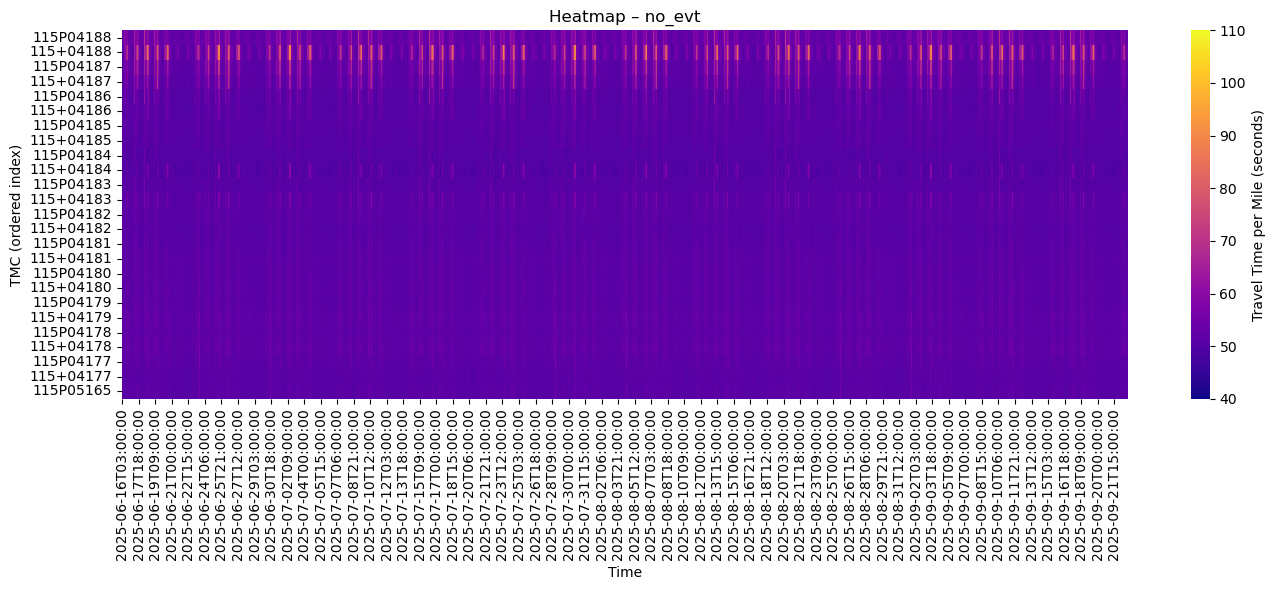

=== plnd_evt ===


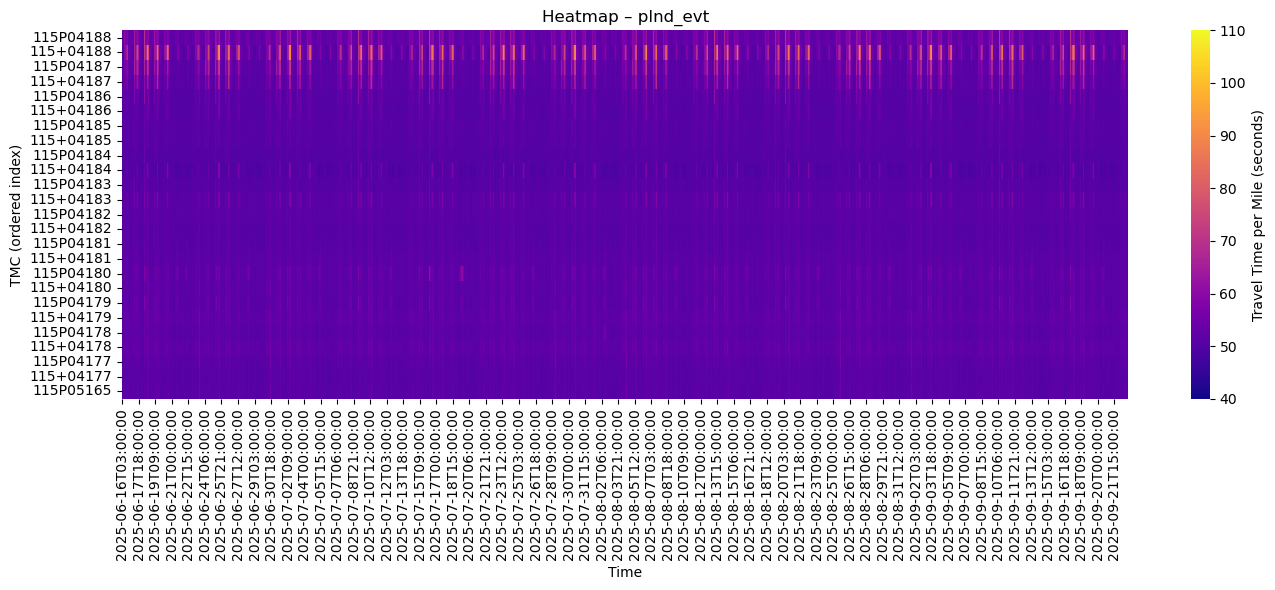

In [167]:
# compare prediction heatmaps (sklearn models)

# Chronological split
test_frac = 0.2
n_test = int(T * test_frac)

# Prepare storage for heatmaps
for name, model in models.items():

    print(f"=== {name} ===")

    # Build feature matrices for all TMCs and all timesteps
    feature_cols = model.regressor_.feature_names_in_.tolist()

    preds_full = []
    for tmc in tmc_order:
        grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
        X_tmc = grp[feature_cols]
        pred = model.predict(X_tmc)
        preds_full.append(pred)

    preds_full = np.array(preds_full)  # Now shape is [N, T]

    # Now reshape to [T, N]
    preds_2d = preds_full.T
    models[name].preds = preds_2d

    # Plot heatmap of predictions
    _=m.plot_heatmap_travel_time(
        preds=preds_2d,
        time_index=time_index,
        tmc_order=tmc_order,
        title=f"Heatmap – {name}",
        cmap='plasma',
        vmin=40, vmax=110
    )

(2374, 25)


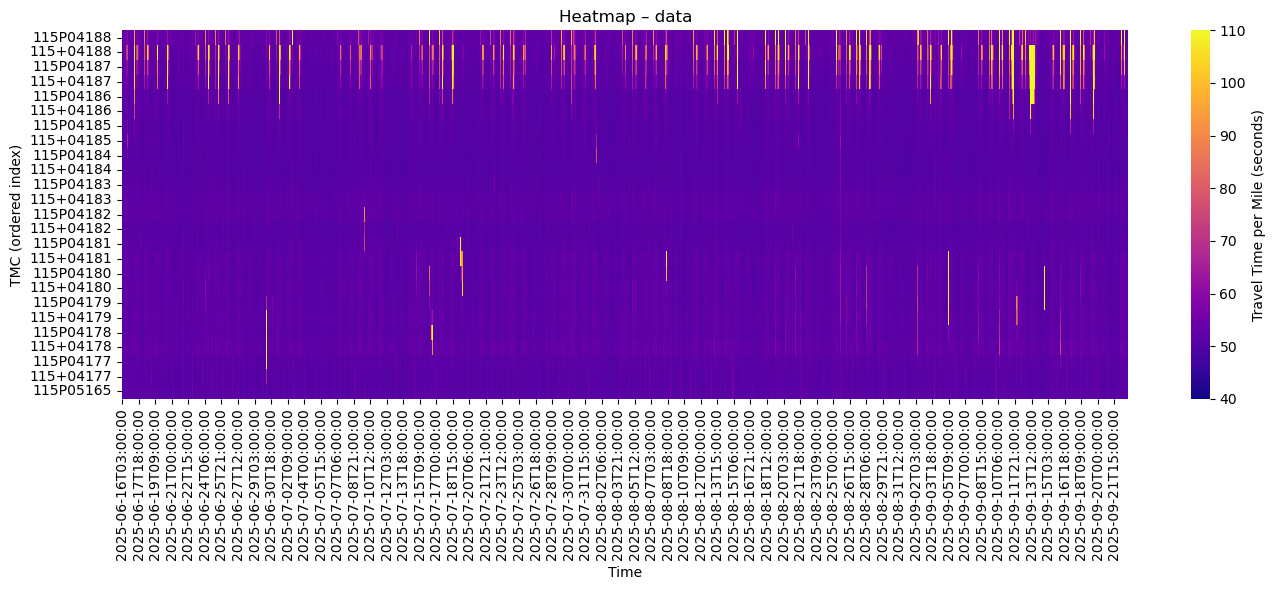

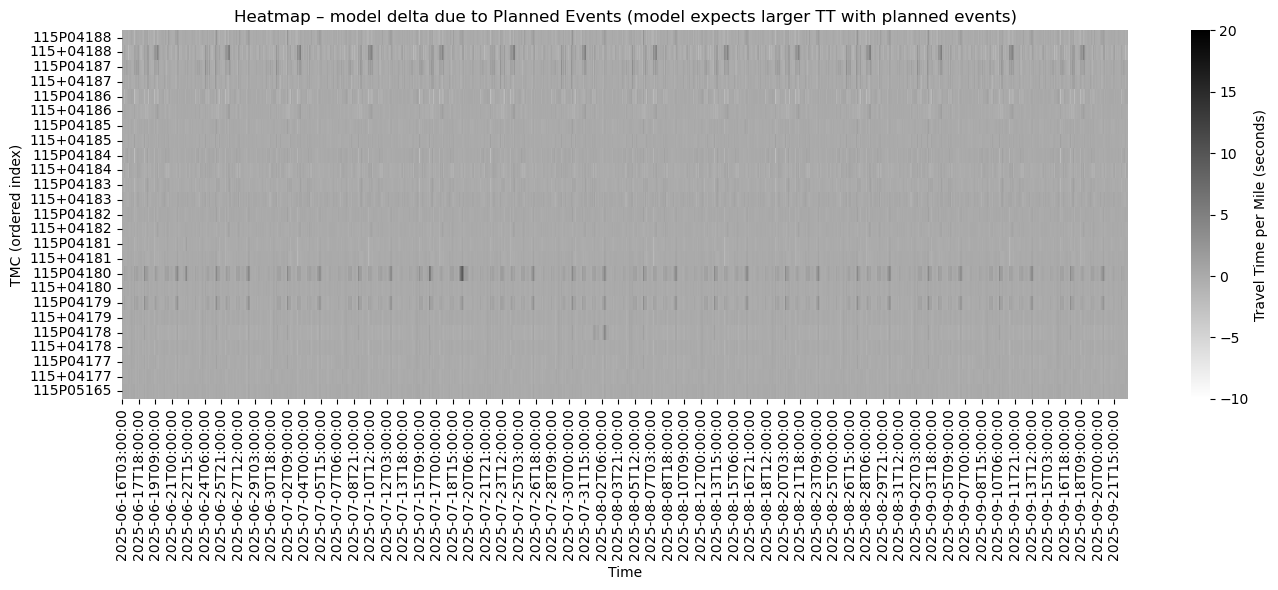

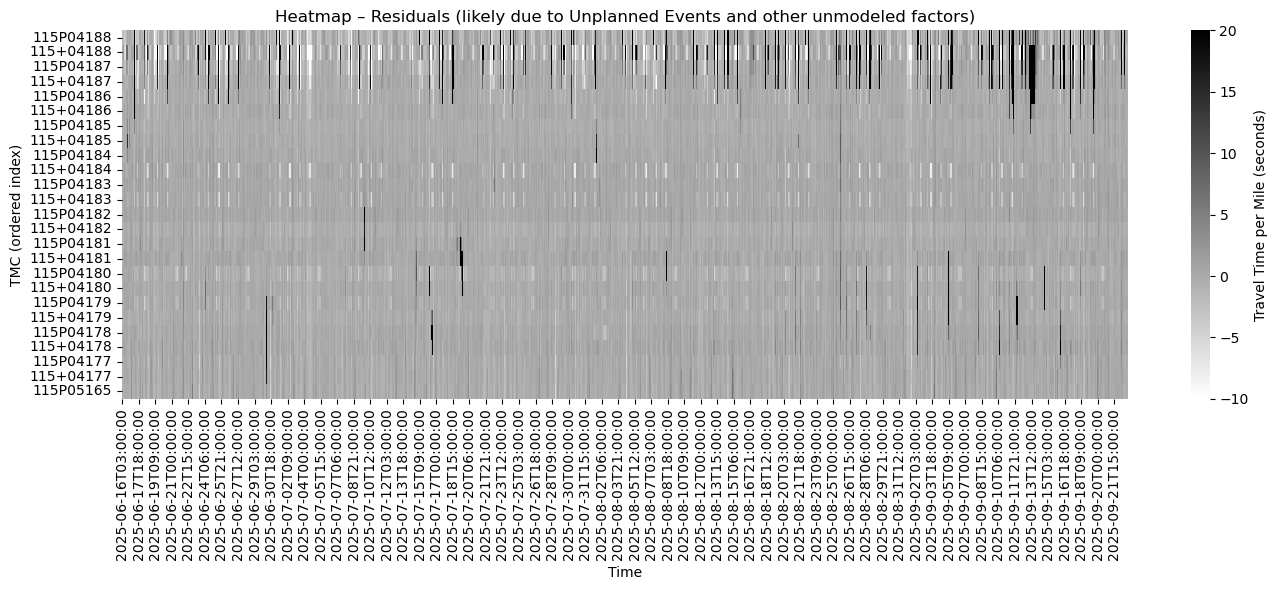

In [168]:
diff = models['plnd_evt'].preds - models['no_evt'].preds # positive: delay due to planned events  (2374, 25)
data_2d = X_full[TARGET_COL].unstack(level='tmc_code')[tmc_order]
print(data_2d.shape)
residuals = data_2d - models['plnd_evt'].preds  # (2374, 25)

data_2d = m.plot_heatmap_travel_time(
        preds=data_2d,
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – data",
        cmap='plasma',
        vmin=40, vmax=110
    )

df_diff = m.plot_heatmap_travel_time(
        preds=diff,
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – model delta due to Planned Events (model expects larger TT with planned events)",
        cmap='gray_r',
        vmin=-10, vmax=20
    )

df_residuals = m.plot_heatmap_travel_time(
        preds=residuals,
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – Residuals (likely due to Unplanned Events and other unmodeled factors)",
        cmap='gray_r',
        vmin=-10, vmax=20
    )

In [169]:
df_residuals.describe()

,115P04188,115+04188,115P04187,115+04187,115P04186,115+04186,115P04185,115+04185,115P04184,115+04184,...,115+04181,115P04180,115+04180,115P04179,115+04179,115P04178,115+04178,115P04177,115+04177,115P05165
count,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,...,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000,2374.000000
mean,1.844538,2.675989,2.178945,2.751936,0.508164,0.030511,-0.243095,-0.058909,0.069425,-0.263952,...,0.577539,-0.286956,0.393647,-0.016502,-0.013487,0.465584,0.418825,-0.003761,0.031097,-0.078876
std,11.610510,17.552082,13.649400,16.779683,7.803121,2.767133,0.885056,2.070624,1.259848,1.742851,...,6.072286,4.803590,10.779087,3.594538,3.561936,6.419318,4.167986,2.108627,1.031621,1.086996
min,-12.047749,-31.325230,-14.521162,-14.258806,-9.265147,-5.253559,-3.089939,-2.575314,-3.803702,-8.468401,...,-2.106782,-5.672207,-4.428902,-6.045881,-4.729722,-3.805085,-3.840941,-5.762511,-4.237919,-5.495269
25%,-2.037960,-3.308376,-1.587109,-0.809884,-0.719812,-0.531318,-0.658055,-0.528278,-0.368113,-0.459252,...,-0.282453,-1.029882,-0.430943,-0.713966,-0.684091,-0.359511,-0.288724,-0.523832,-0.522810,-0.615482
50%,-0.706110,-0.503855,-0.439161,-0.092635,-0.258715,-0.097775,-0.302682,-0.152068,0.010491,0.121219,...,0.185557,-0.466507,-0.002046,-0.150348,-0.223061,0.129664,0.202715,-0.010241,-0.015402,-0.151012
75%,0.819997,1.062920,0.645302,0.558724,0.159964,0.336863,0.068651,0.242005,0.396612,0.626833,...,0.658627,0.050428,0.409613,0.354784,0.201470,0.534592,0.693789,0.427400,0.440449,0.356246
max,140.845521,198.702294,175.803676,220.715723,115.846799,76.351596,12.891164,86.087313,36.435813,5.914925,...,197.769028,156.478880,501.896343,106.888283,136.637442,190.758200,182.447138,88.857354,16.733421,8.378981


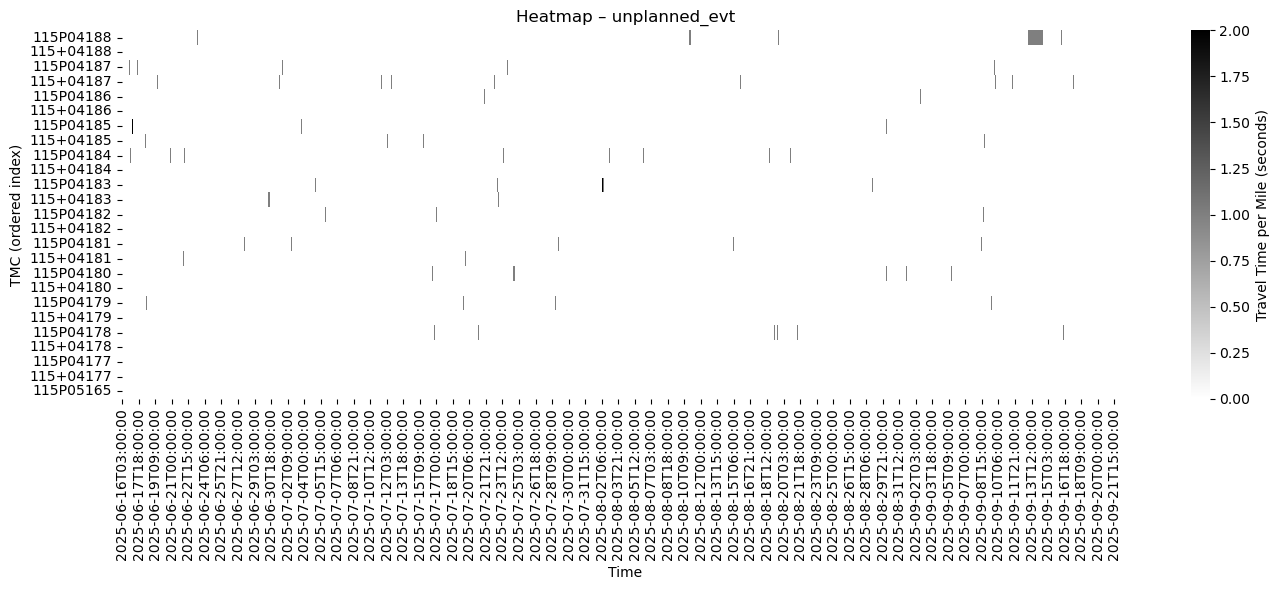

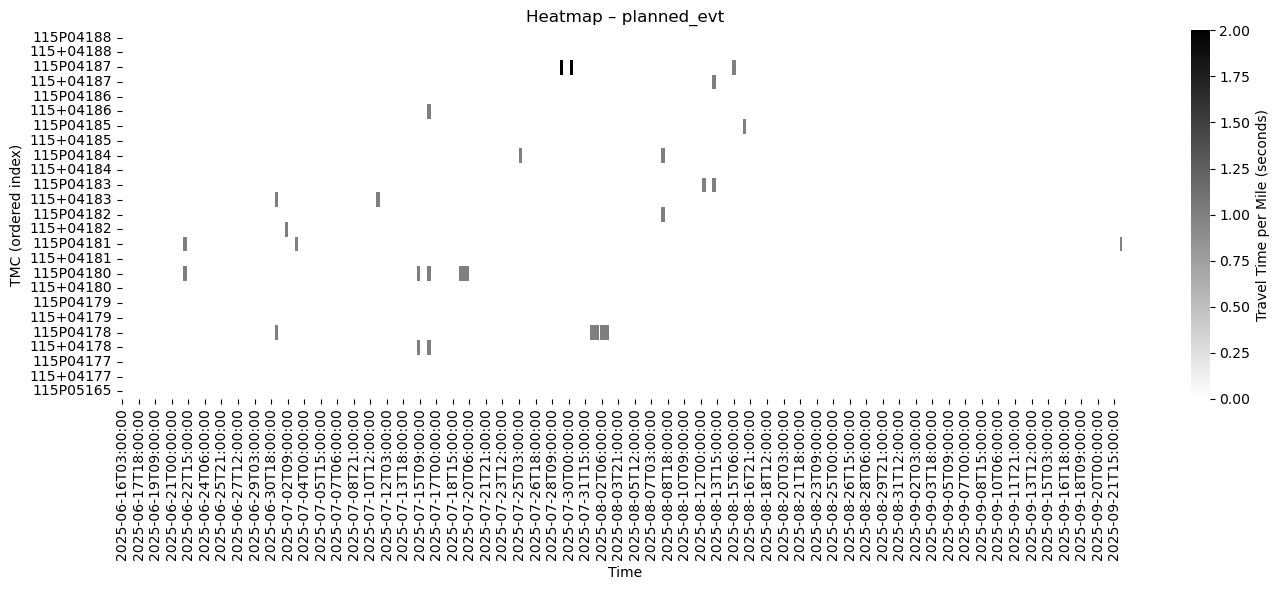

In [170]:
# get planned event 2d heatmap from the same direction in the same TMC order

df_unplnd_evt = m.plot_heatmap_travel_time(
        preds=X_full['evt_cat_unplanned'].unstack(level='tmc_code').fillna(0)[tmc_order],
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – unplanned_evt",
        cmap='gray_r',
        # vmin=-2, vmax=20
    )
df_plnd_evt = m.plot_heatmap_travel_time(
        preds=X_full['evt_cat_planned'].unstack(level='tmc_code').fillna(0)[tmc_order],
        time_index=time_index,
        tmc_order=tmc_order,
        title="Heatmap – planned_evt",
        cmap='gray_r',
        # vmin=-2, vmax=20
    )

## Correlation analysis

In [171]:
df_long = (
    df_diff.stack()
    .rename("diff")
    .to_frame()
    .join(df_residuals.stack().rename("residuals"))
    .join(df_plnd_evt.stack().rename("plnd_evt"))
    .join(df_unplnd_evt.stack().rename("un_plnd_evt"))
    .reset_index()
    .rename(columns={"level_0": "time_bin", "level_1": "tmc"})
)

df_long['hour'] = df_long['time_bin'].dt.hour
df_long['dow'] = df_long['time_bin'].dt.dayofweek  # Monday=0, Sunday=6

# select the middle 95% quantile based on diff value
# df_long = df_long[df_long['diff'].between(df_long['diff'].quantile(0.001), df_long['diff'].quantile(0.999))]
df_long.head(3)

,time_bin,tmc,diff,residuals,plnd_evt,un_plnd_evt,hour,dow
0,2025-06-16 03:00:00+00:00,115P04188,-0.008545,0.189148,0,0,3,0
1,2025-06-16 03:00:00+00:00,115+04188,-0.478283,1.108154,0,0,3,0
2,2025-06-16 03:00:00+00:00,115P04187,-0.205894,0.214336,0,0,3,0


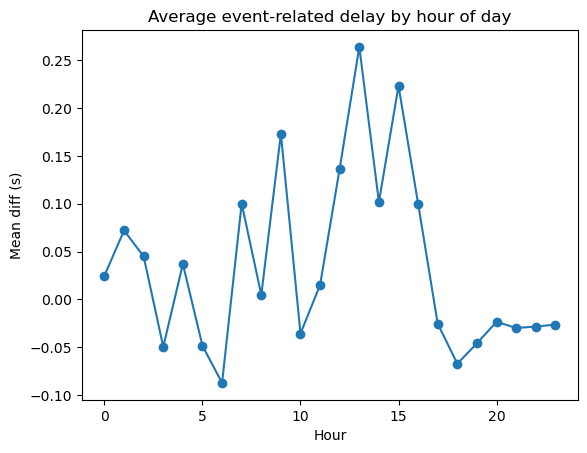

In [172]:
# Mean diff by hour (only during events)
event_mask = (df_long["plnd_evt"] == 1) | (df_long["un_plnd_evt"] == 1)
df_long.groupby("hour")["diff"].mean().plot(marker='o') # filter by event_mask if event data is reliable .loc[event_mask]
plt.title("Average event-related delay by hour of day")
plt.ylabel("Mean diff (s)")
plt.xlabel("Hour")
plt.show()

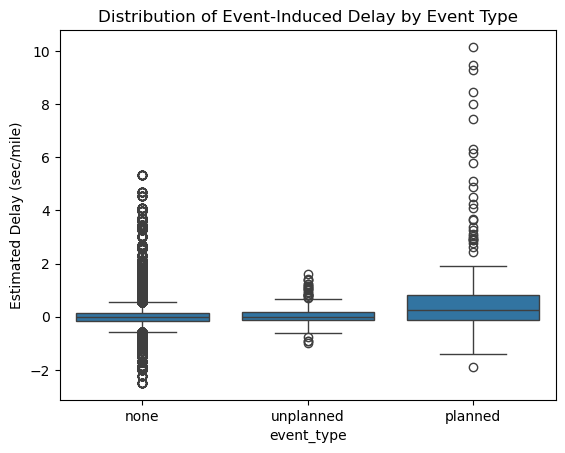

In [173]:

df_long["event_type"] = np.select(
    [df_long["plnd_evt"] == 1, df_long["un_plnd_evt"] == 1],
    ["planned", "unplanned"],
    default="none"
)

sns.boxplot(x="event_type", y="diff", data=df_long)
plt.ylabel("Estimated Delay (sec/mile)")
plt.title("Distribution of Event-Induced Delay by Event Type")
plt.show()


Spatial correlation (Pearson): 0.293
Spatial correlation (Spearman): 0.027


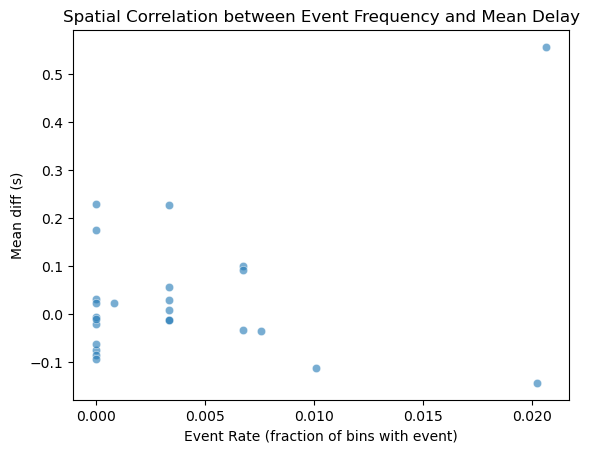

In [174]:
# Spatial correlation
# Are segments (TMCs) that have more frequent events also the ones with higher mean travel time impact (diff)?
# total number of event time bins per TMC
df_long["event_flag"] = (df_long["plnd_evt"] == 1) #| (df_long["un_plnd_evt"] == 1)

agg_spatial = (
    df_long.groupby("tmc")
    .agg(
        mean_diff=("diff", "mean"),
        event_rate=("event_flag", "mean"),   # proportion of bins with event
        n_events=("event_flag", "sum")
    )
    .reset_index()
)
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(agg_spatial["mean_diff"], agg_spatial["event_rate"])
spearman_corr, _ = spearmanr(agg_spatial["mean_diff"], agg_spatial["event_rate"])
print(f"Spatial correlation (Pearson): {pearson_corr:.3f}")
print(f"Spatial correlation (Spearman): {spearman_corr:.3f}")
sns.scatterplot(
    x="event_rate", y="mean_diff", data=agg_spatial, alpha=0.6
)
plt.title("Spatial Correlation between Event Frequency and Mean Delay")
plt.xlabel("Event Rate (fraction of bins with event)")
plt.ylabel("Mean diff (s)")
plt.show()

Temporal correlation (zero lag): 0.083


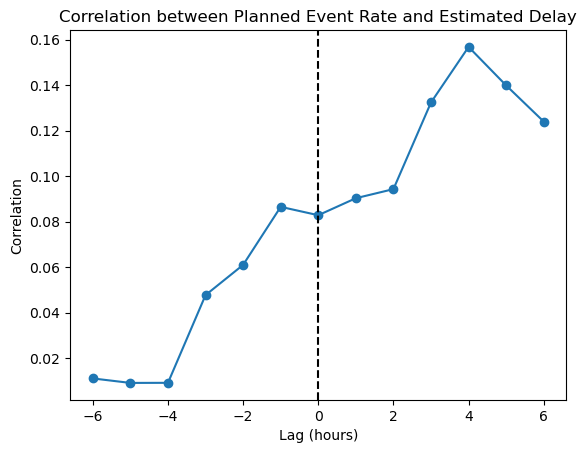

In [175]:
# Temporal correlation between diff and events
# Do high diff periods coincide with event times, and is there a temporal lag (before or after event reports)?
agg_temporal = (
    df_long.groupby("time_bin")
    .agg(
        mean_diff=("diff", "mean"),
        event_rate=("event_flag", "mean")
    )
    .reset_index()
)
# compute correlation at zero lag
pearson_corr, _ = pearsonr(agg_temporal["mean_diff"], agg_temporal["event_rate"])
print(f"Temporal correlation (zero lag): {pearson_corr:.3f}")

# optional: cross-correlation for lags (±n bins)
lags = np.arange(-6, 7)
corr = [
    np.corrcoef(
        np.roll(agg_temporal["event_rate"], l), agg_temporal["mean_diff"]
    )[0, 1]
    for l in lags
]

plt.plot(lags, corr, marker="o")
plt.axvline(0, color="k", linestyle="--")
plt.title("Correlation between Planned Event Rate and Estimated Delay")
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.show()

# correlation peaks at lag = 4hr, delay tend to continue after events.

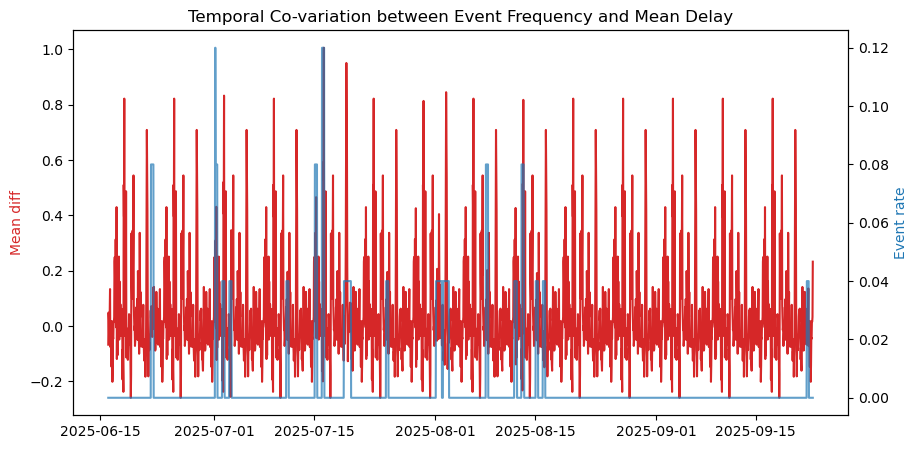

In [176]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(agg_temporal["time_bin"], agg_temporal["mean_diff"], color="tab:red", label="Mean diff")
ax1.set_ylabel("Mean diff", color="tab:red")

ax2 = ax1.twinx()
ax2.plot(agg_temporal["time_bin"], agg_temporal["event_rate"], color="tab:blue", alpha=0.7, label="Event rate")
ax2.set_ylabel("Event rate", color="tab:blue")

plt.title("Temporal Co-variation between Event Frequency and Mean Delay")
plt.show()

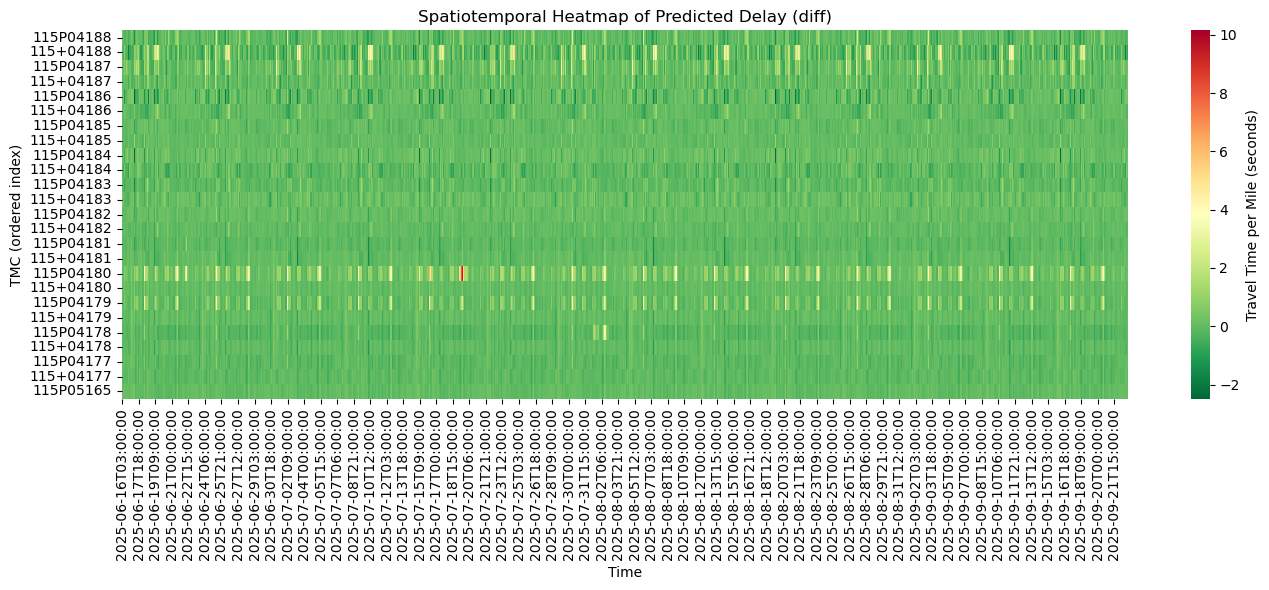

In [177]:
pivot_diff = df_long.pivot_table(
    index="tmc", columns="time_bin", values="diff", aggfunc="mean"
)
_=m.plot_heatmap_travel_time(
    preds=pivot_diff.loc[tmc_order].values.T, # reorder tmcs
    time_index=pivot_diff.columns,
    tmc_order=tmc_order,
    title="Spatiotemporal Heatmap of Predicted Delay (diff)",
    cmap="RdYlGn_r",
)

# plt.figure(figsize=(12,6))
# sns.heatmap(pivot_diff, cmap="RdYlGn_r", cbar_kws={'label': 'diff'})
# plt.title("Spatiotemporal Heatmap of Predicted Delay (diff)")
# plt.xlabel("Time")
# plt.ylabel("TMC")
# plt.show()

In [178]:
from scipy.stats import ttest_ind

planned = df_long.loc[df_long["plnd_evt"] == 1, "diff"]
unplanned = df_long.loc[df_long["plnd_evt"] != 1, "diff"]

t_stat, p_val = ttest_ind(planned, unplanned, equal_var=False)
print(f"T-statistic = {t_stat:.2f}, p-value = {p_val:.3e}")

T-statistic = 6.30, p-value = 1.428e-09


In [179]:
print("Overall correlation (df_diff vs planned_evt):", df_long["diff"].corr(df_long["plnd_evt"]))
print("Overall correlation (df_residual vs planned_evt):", df_long["residuals"].corr(df_long["plnd_evt"]))
print("Overall correlation (df_residual vs un_planned_evt):", df_long["residuals"].corr(df_long["un_plnd_evt"]))

Overall correlation (df_diff vs planned_evt): 0.0950151994049318
Overall correlation (df_residual vs planned_evt): -0.0017708104916432643
Overall correlation (df_residual vs un_planned_evt): 0.012268166813072207


In [180]:
df_long['diff'].describe()

count    59350.000000
mean         0.034562
std          0.457569
min         -2.489777
25%         -0.147861
50%         -0.016640
75%          0.134487
max         10.149925
Name: diff, dtype: float64

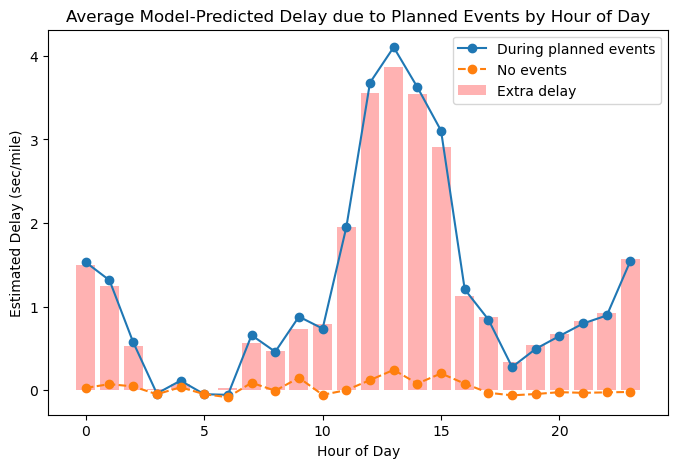

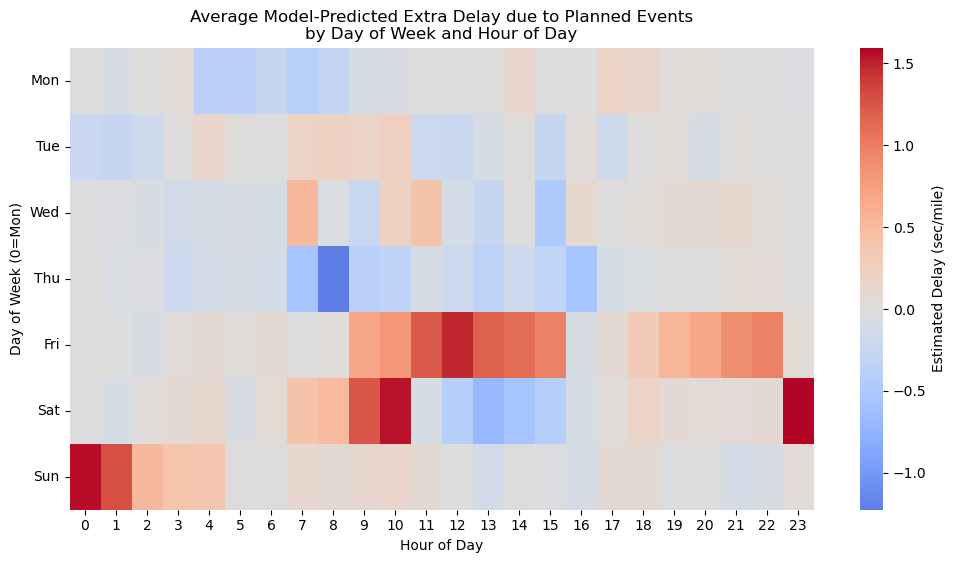

In [181]:
# answer “the delay due to planned events at each hour of the day” 

def middle_mean(x):
    lower, upper = x.quantile([0.01, 0.99])
    trimmed = x[(x >= lower) & (x <= upper)]
    return trimmed.mean()

# Step 3: group by hour and event condition
grouped = (
    df_long.groupby(['hour', (df_long['plnd_evt'] > 0)])['diff']
    .apply(middle_mean)
    .fillna(0)
    .unstack(fill_value=0)
    .rename(columns={False: 'no_event', True: 'with_event'})
)
grouped_2d = (
    df_long.groupby(['dow', 'hour', (df_long['plnd_evt'] > 0)])['diff']
    .apply(middle_mean)
    .fillna(0)
    .unstack(fill_value=0)
    .rename(columns={False: 'no_event', True: 'with_event'})
)
# Step 4: compute difference
grouped['extra_delay'] = grouped['with_event'] - grouped['no_event']
grouped_2d['extra_delay'] = grouped_2d['with_event'] - grouped_2d['no_event']

plt.figure(figsize=(8,5))
plt.plot(grouped.index, grouped['with_event'], label='During planned events', marker='o')
plt.plot(grouped.index, grouped['no_event'], label='No events', marker='o', linestyle='--')
plt.bar(grouped.index, grouped['extra_delay'], alpha=0.3, label='Extra delay', color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Delay (sec/mile)')
plt.title('Average Model-Predicted Delay due to Planned Events by Hour of Day')
plt.legend()
plt.show()

# Pivot to 2D matrix for plotting
heatmap_data = grouped_2d['extra_delay'].unstack(level='hour')

# Order weekdays (optional: 0=Mon to 6=Sun)
plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Estimated Delay (sec/mile)'}
)
plt.title('Average Model-Predicted Extra Delay due to Planned Events\nby Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon)')
plt.yticks(ticks=np.arange(0.5,7.5,1), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
plt.show()

## 2D correlation
	•	df_plnd_evt (planned event intensity  →  input)
	•	df_unplnd_evt (unplanned events  →  input)
	•	df_diff (model delta →  response),

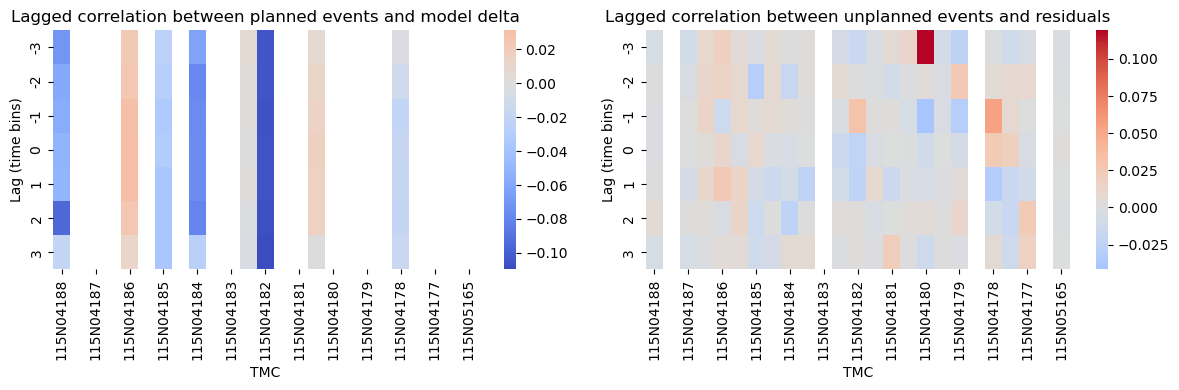

In [26]:
lags = range(-3, 4)  # e.g., ±1 hours
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
corrs = pd.DataFrame(index=df_plnd_evt.columns, columns=lags)
for lag in lags:
    shifted = df_plnd_evt.shift(lag)
    corrs[lag] = shifted.corrwith(df_diff)

sns.heatmap(corrs.T, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_xlabel("TMC")
axes[0].set_ylabel("Lag (time bins)")
axes[0].set_title("Lagged correlation between planned events and model delta")

corrs = pd.DataFrame(index=df_unplnd_evt.columns, columns=lags)
for lag in lags:
    shifted = df_unplnd_evt.shift(lag)
    corrs[lag] = shifted.corrwith(df_residuals)

sns.heatmap(corrs.T, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_xlabel("TMC")
axes[1].set_ylabel("Lag (time bins)")
axes[1].set_title("Lagged correlation between unplanned events and residuals")

plt.tight_layout()
plt.show()